# Readme

**Data cleaning**

Some trials were removed due to either atypical response, or measurements that started more than one day after fertilizer application, or emissions that started at t>0 after manure application. Measurements taken after 178 hours were excluded. For trials with measurements preceding manure application, we interpolated cumulative emissions at t = 0 (time of manure application) and removed all earlier measurements so that the first time interval begins at t = 0. In such cases, cumulative emissions at t = 0 were subtracted from all subsequent values, assuming that emissions begin only after manure application. For trials with more than 50 time points, we kept only a subset of points closest to a reference time sequence, defined with a time step of 2 hours between 0-12 h, 4 hours between 12-24 h, and 8 hours between 24-178 h. Missing values for manure pH were imputed using the average pH per manure origin. Missing values for air temperature and wind speed were linearly interpolated, while missing rainfall values were replaced with zeros.


# Setup

In [38]:
library ("ggplot2")
library ("dplyr") 
library ("tibble")
library ("tidyr")
library ("kableExtra")
library ("stringr")

source (file = "../../01_functions/functions.R")

# Data

In [39]:
idat <- read.csv('../../00_data/ALFAM2_interval.csv')
pdat <- read.csv('../../00_data/ALFAM2_plot.csv')

In [40]:
# pmids used in Hafner et al. (2025)
pmid1 <- read.table('../../00_data/pmids_Hafner_et_al_2025.txt')[[1]]

In [41]:
length (pmid1)

[1] 722

In [42]:
idat = idat %>%
    mutate (t.start = as.POSIXct (t.start, format = "%Y-%m-%d %H:%M:%S")) %>%
    mutate (t.end = as.POSIXct (t.end, format = "%Y-%m-%d %H:%M:%S"))

pdat = pdat %>%
    mutate (app.start = as.POSIXct (app.start, format = "%Y-%m-%d %H:%M:%S"))

In [43]:
pdat = pdat %>%
    filter (pmid %in% pmid1)

In [44]:
data = idat %>%
    filter (pmid %in% pmid1) %>%
    left_join (pdat, by = c ("pid", "pmid"))

In [45]:
dim (data)

[1] 19230   265

In [46]:
data$pmid %>% unique %>% length

[1] 722

There are problems with some trials:

- pmids 1517 and 1519: mesures start ~1 day and ~4 days after manure application
- pmids 1514, 1516, 1523, 1525: emissions start at t>0 after manure application
- pmid 915, 986, 1183: atypical response

In [9]:
idat %>%
    filter (pmid == 1517) %>%
    select (pmid, ct, cta, dt, e.cum) %>%
    head (n = 2)

,pmid,ct,cta,dt,e.cum
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1517,0.25,96.75,0.25,0.03870
2,1517,0.50,97.00,0.25,0.08253


In [10]:
idat %>%
    filter (pmid == 1519) %>%
    select (pmid, ct, cta, dt, e.cum) %>%
    head (n = 2)

,pmid,ct,cta,dt,e.cum
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1519,0.25,24.25,0.25,0.13482
2,1519,0.50,24.50,0.25,0.25245


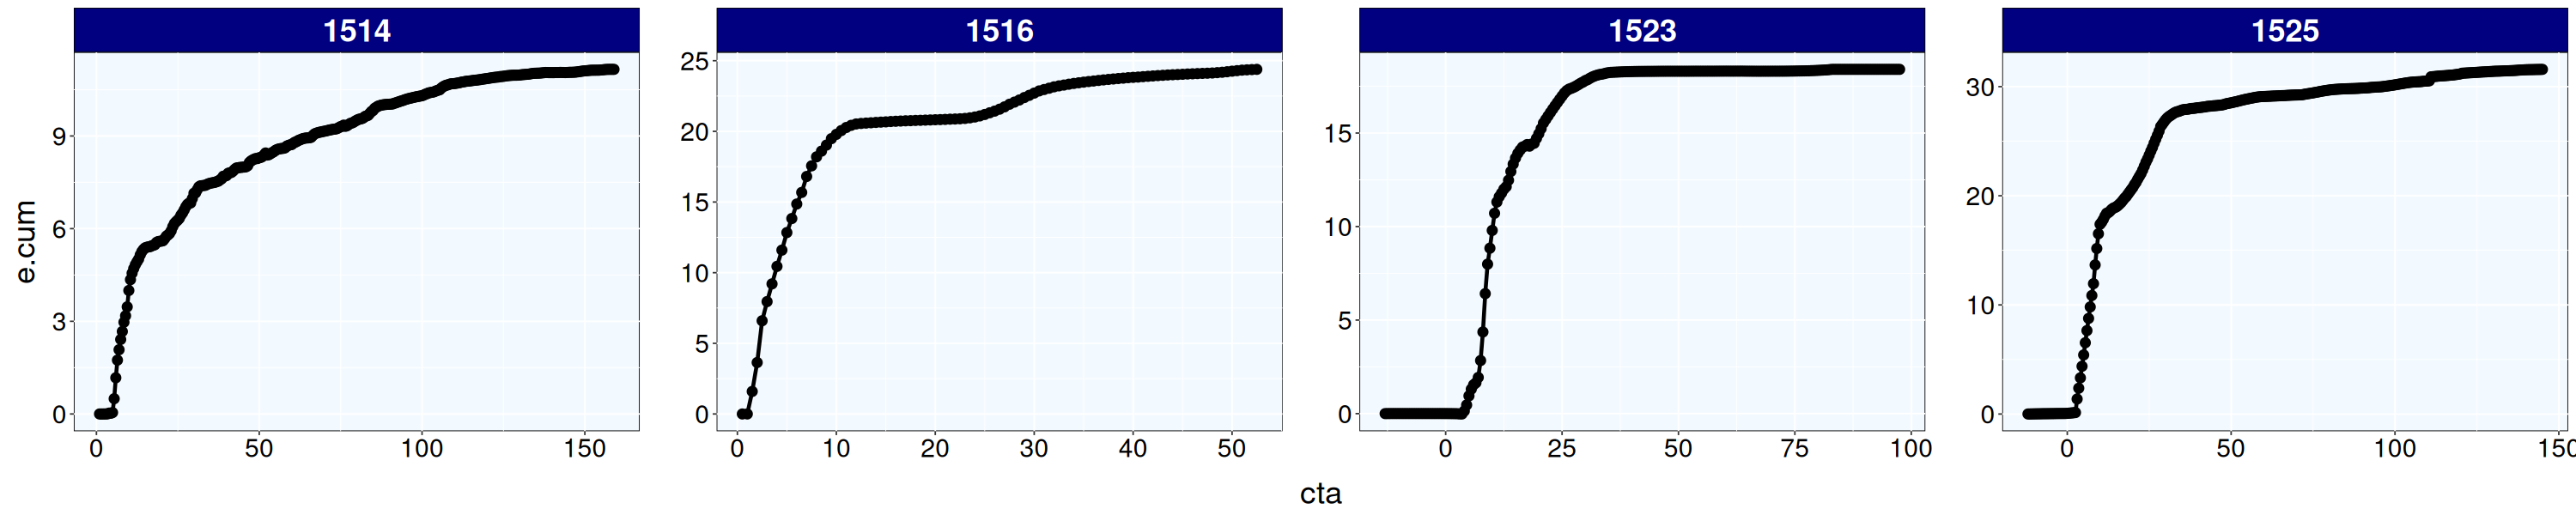

In [11]:
size (25, 5)
idat %>%
    filter (pmid %in% c (1514, 1516, 1523, 1525)) %>%
    ggplot () +
        geom_point (aes (x = cta, y = e.cum)) +
        geom_line (aes (x = cta, y = e.cum)) +
        facet_wrap (~ pmid, scales = "free", ncol = 4)

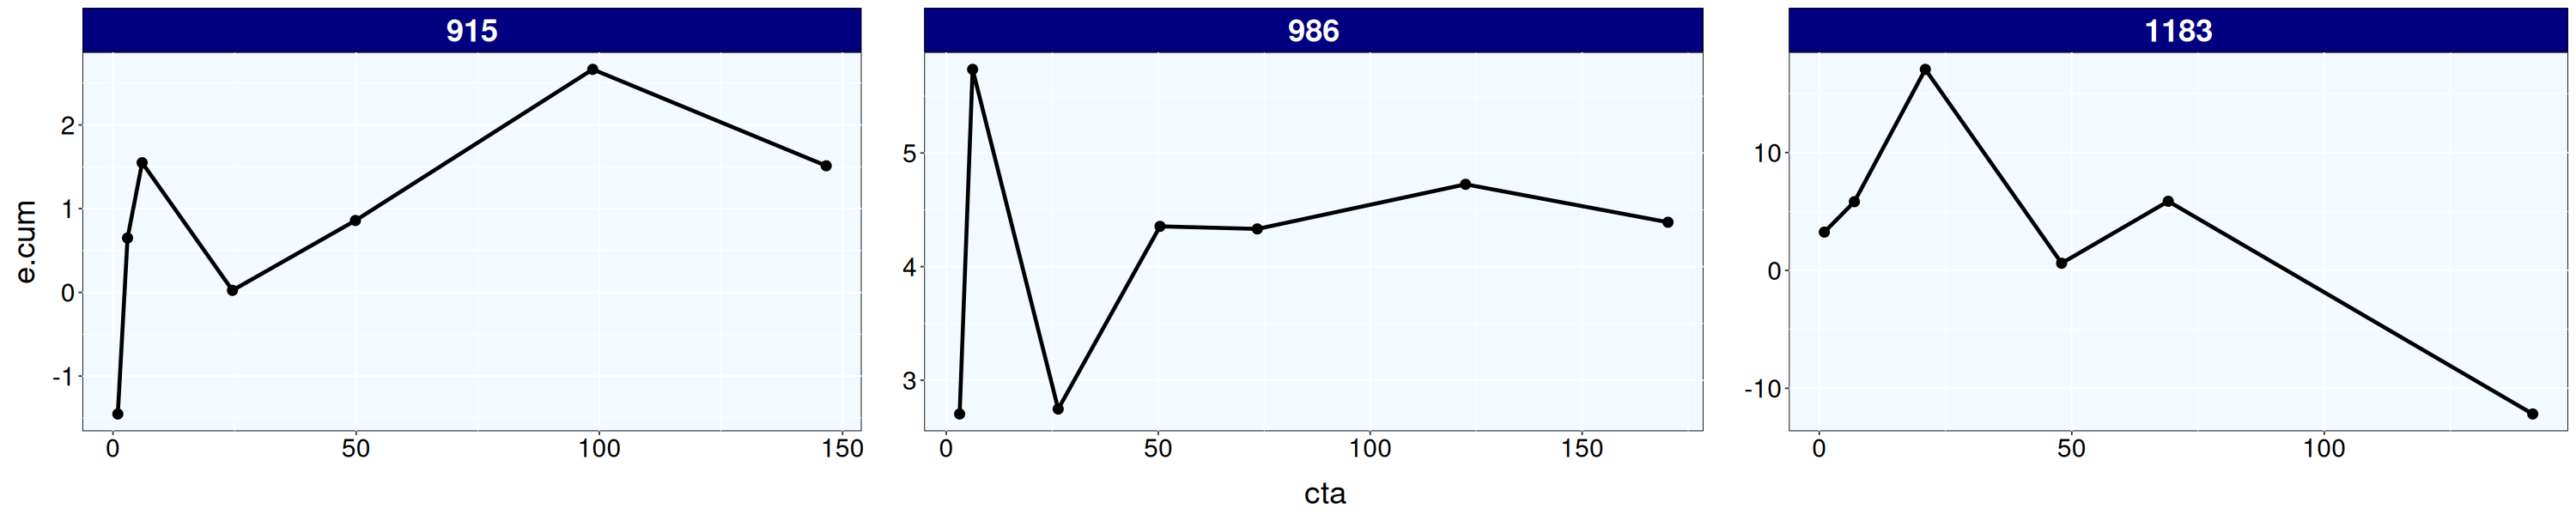

In [12]:
size (25, 5)
idat %>%
    filter (pmid %in% c (915, 986, 1183)) %>%
    ggplot () +
        geom_point (aes (x = cta, y = e.cum)) +
        geom_line (aes (x = cta, y = e.cum)) +
        facet_wrap (~ pmid, scales = "free", ncol = 3)

We remove these pmids.

In [13]:
data = data %>%
    filter (!(pmid %in% c (915, 986, 1517, 1519, 1514, 1516, 1523, 1525, 1183)))

In [46]:
data$pmid %>% unique %>% length

[1] 722

In some cases, measurements started more than 0.5h after application.

In [14]:
pmids_to_remove = data %>%
    filter (pmid %in% pmid[(cta[1] - dt[1]) > 0.5], .by = pmid) %>%
    pull (pmid) %>% unique

In [15]:
length (pmids_to_remove)

[1] 14

We remove these pmids.

In [16]:
data = data %>%
    filter (!(pmid %in% pmids_to_remove))

When cta (cumulative time since application) is known, we use it instead of ct (cumulative time since first measurement). We then have to recompute dt, because in some cases there are unexplained differences between cta and ct. For example with pmid 963:

In [17]:
data %>%
    filter (pmid == 963) %>%
    select (pmid, ct, cta, dt, j.NH3) 

pmid,ct,cta,dt,j.NH3
<int>,<dbl>,<dbl>,<dbl>,<dbl>
963,1.0,1.000,1.0,1.914
963,3.0,3.000,2.0,1.240
963,6.0,6.000,3.0,0.586
963,25.1,25.500,19.1,0.346
963,49.4,49.750,24.3,0.027
963,76.9,93.917,27.5,0.042
963,119.4,148.420,42.5,0.036


To recompute dt, we need to shift ct, and we set first value equal to zero. 

In [18]:
data = data %>%
    mutate (ct_old = ct) %>%
    mutate (ct = ifelse (is.na (cta), ct, cta)) %>%
    mutate (ct_shift = c (0, ct [1 : (n() - 1)]), .by = pmid) %>%
    mutate (dt_new = ct - ct_shift)

We check the differences between new and old values.

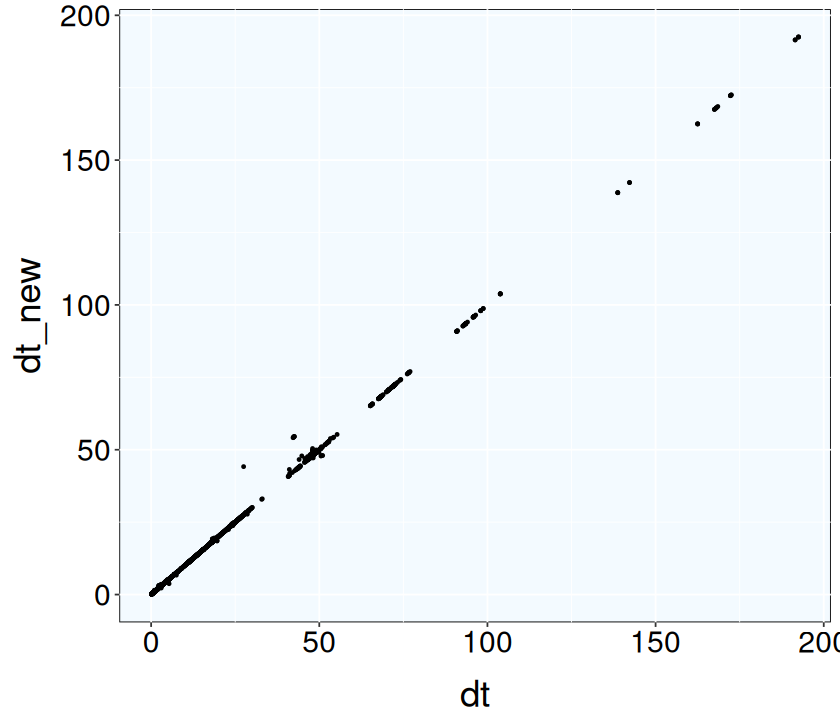

In [19]:
size (7, 6)
data %>%
    filter (ct > 0) %>%
    ggplot() + geom_point (aes (x = dt, y = dt_new), size = 0.7)

Differences above 10 correspond to the following cases:

In [20]:
data %>%
    filter (ct > 0) %>%
    filter (abs (dt - dt_new) > 10) %>%
    select (pmid, ct_old, cta, dt, dt_new, j.NH3) 

pmid,ct_old,cta,dt,dt_new,j.NH3
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
946,135.5,147.330,42.2,54.163,0.031
950,136.6,148.580,42.4,54.413,0.037
953,135.7,147.670,42.5,54.503,0.042
959,135.4,147.420,42.6,54.587,0.015
963,76.9,93.917,27.5,44.167,0.042
963,119.4,148.420,42.5,54.503,0.036
965,135.5,147.420,42.3,54.253,0.023


In [21]:
data %>%
    filter (pmid == 963) %>%
    select (pmid, ct_old, cta, dt, dt_new, j.NH3) 

pmid,ct_old,cta,dt,dt_new,j.NH3
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
963,1.0,1.000,1.0,1.000,1.914
963,3.0,3.000,2.0,2.000,1.240
963,6.0,6.000,3.0,3.000,0.586
963,25.1,25.500,19.1,19.500,0.346
963,49.4,49.750,24.3,24.250,0.027
963,76.9,93.917,27.5,44.167,0.042
963,119.4,148.420,42.5,54.503,0.036


In some cases, measurements started before application, and cumulative emissions are > 0 at application time. Because we are only interested in cumulative emissions after application, we interpolated cumulative emissions at time = 0 (application) and we subtracted this amount from all cumulative values for each pmid.

We then removed measurements made before application and we recomputed j.NH3 and e.rel. 

In [22]:
interpolated_cumul_at_time_0 = NULL

pmids_data = data$pmid %>% unique

for (i in c (1 : length (pmids_data))){
    
    data_tmp = data %>% filter (pmid == pmids_data[i]) 

    if (is.na (data_tmp$ct[1]) | data_tmp$ct[1] > 0){
        df = data.frame (pmid = data_tmp$pmid[1], e.cum_0 = 0)
    }

    else{
        e.cum_0 = approx (data_tmp$ct, data_tmp$e.cum, xout = 0, rule = 2)
        df = data.frame (pmid = data_tmp$pmid[1], e.cum_0 = e.cum_0$y)
    }
    
    interpolated_cumul_at_time_0 = rbind (interpolated_cumul_at_time_0, df)
    
}

In [23]:
interpolated_cumul_at_time_0 %>%
    filter (e.cum_0 != 0)

pmid,e.cum_0
<int>,<dbl>
1522,-0.878530000
1524,-0.169690000
1527,0.289410000
1528,1.909900000
1935,0.037664000
1936,0.010854252
1937,-0.008938950
1938,0.054367285
2233,0.112650562


In [24]:
data = data %>%
    left_join (interpolated_cumul_at_time_0, by = "pmid") %>%
    mutate (e.cum_new = e.cum - e.cum_0) %>%
    mutate (e.cum_shift_new = c (0, e.cum_new [1 : (n() - 1)]), .by = pmid) %>%
    mutate (j.NH3_new = (e.cum_new - e.cum_shift_new) / dt_new) %>%
    mutate (e.rel_new = e.cum_new / tan.app) %>%   
    filter (ct > 0)

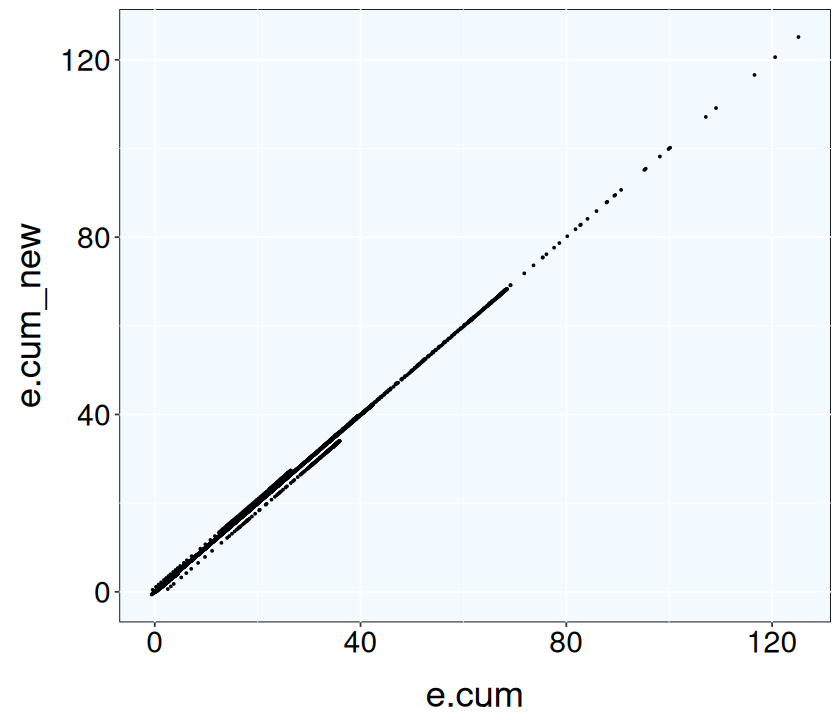

In [25]:
size (7, 6)
data %>%
    ggplot() + geom_point (aes (x = e.cum, y = e.cum_new), size = 0.4)

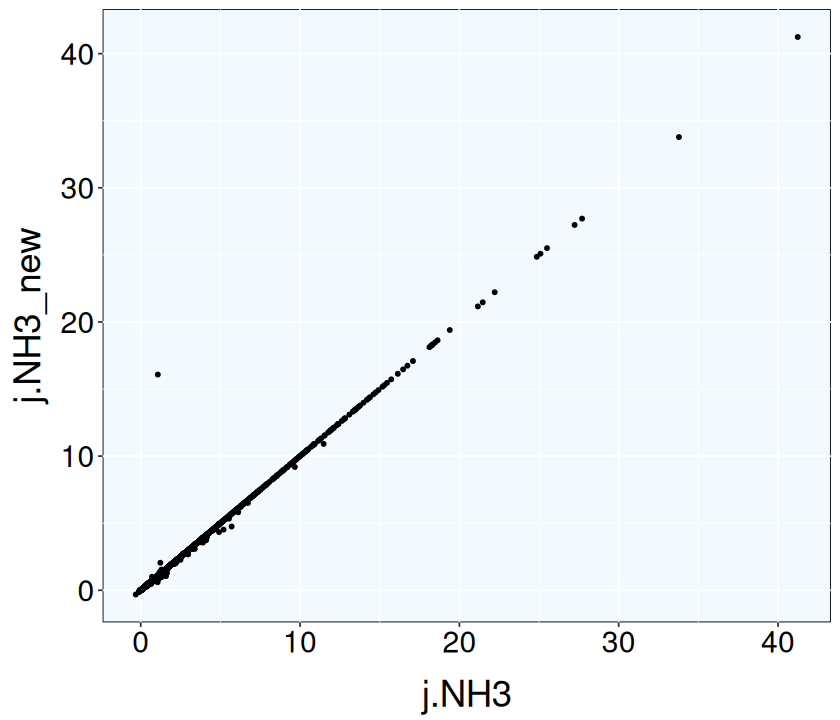

In [26]:
size (7, 6)
data %>%
    ggplot() + geom_point (aes (x = j.NH3, y = j.NH3_new), size = 1)

The point corresponding to the high difference between j.NH3 and j.NH3_new belongs to pmid 1470. In this pmid, the first measurement interval started before application and ended after application:

In [27]:
data %>%
    filter (pmid %in% pmid [abs (j.NH3 - j.NH3_new) > 10]) %>%
    select (pmid, ct_old, cta, dt, j.NH3, j.NH3_new) %>%
    head

,pmid,ct_old,cta,dt,j.NH3,j.NH3_new
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1470,0.25,0.016667,0.25,1.07190,16.077878
2,1470,0.75,0.516670,0.50,2.70040,2.700444
3,1470,1.50,1.266700,0.75,1.73220,1.732064
4,1470,2.50,2.266700,1.00,1.09850,1.098500
5,1470,3.50,3.266700,1.00,0.67214,0.672100
6,1470,5.50,5.266700,2.00,0.33163,0.331650


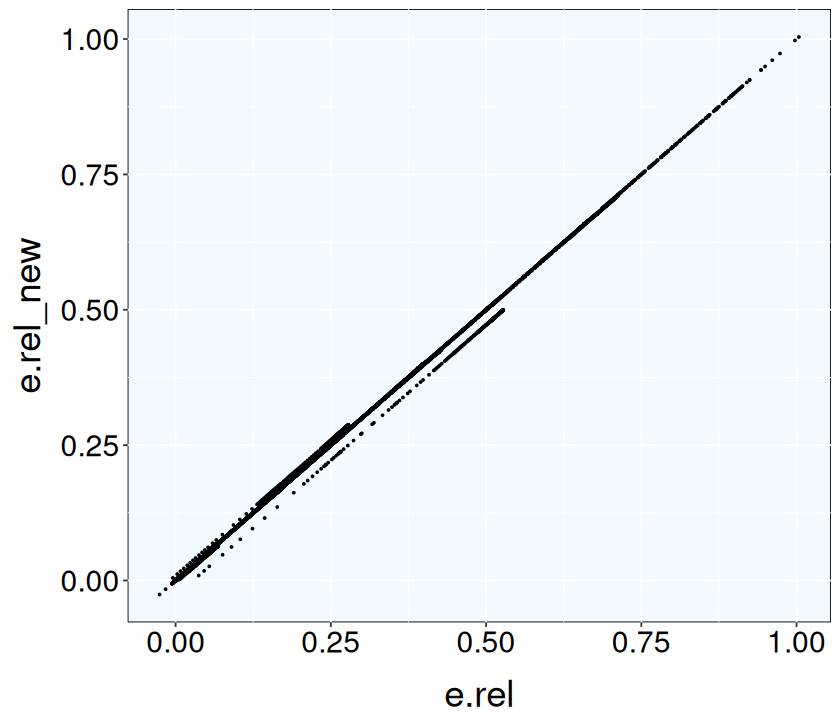

In [28]:
size (7, 6)
data %>%
    ggplot() + geom_point (aes (x = e.rel, y = e.rel_new), size = 0.4)

In [29]:
data = data %>%
    select (- e.cum, - e.rel, - j.NH3, - ct_old, - cta, - dt) %>%
    rename (e.cum = e.cum_new, j.NH3 = j.NH3_new, e.rel = e.rel_new, dt = dt_new)

In [30]:
data = data %>%
    rename (app.mthd = app.method)

Imputation of missing values for pH.

In [31]:
mnph = pdat %>%
    summarise (man.ph.mean = mean (na.omit (man.ph)), 
               man.ph.n = sum (is.na (man.ph)), 
               .by = c (inst, man.source))

In [32]:
data = data %>%
    left_join (mnph, by = c("inst", "man.source"))

In [33]:
data = data %>%
    mutate (man.ph.missing = ifelse (is.na (man.ph), TRUE, FALSE)) %>%
    mutate (man.ph = ifelse (is.na (man.ph), man.ph.mean, man.ph))

Imputation of missing values for wind and temperature.

In [36]:
data %>%
    filter (is.na (air.temp))

pid,pmid,oid,row.in.file.int,interval,t.start,t.end,t.start.orig,t.end.orig,dt.calc,⋯,ct_shift,dt,e.cum_0,e.cum,e.cum_shift_new,j.NH3,e.rel,man.ph.mean,man.ph.n,man.ph.missing
<int>,<int>,<int>,<int>,<int>,<dttm>,<dttm>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
190,190,1764,294,5,1995-06-10 14:45:00,1995-06-13 13:45:00,NA,NA,NA,⋯,95.5,71,0,18.895,18.5110,0.005408451,0.17217970,7.42,0,FALSE
191,191,1769,299,5,1995-06-10 14:43:00,1995-06-13 12:43:00,NA,NA,NA,⋯,95.8,70,0,10.545,9.9429,0.008601429,0.09793814,7.42,0,FALSE


In [34]:
data <- interpm(data, 'ct', c('wind.2m', 'air.temp'), by = 'pmid', rule = 2)

Imputation of missing values for rain.

In [35]:
data = data %>%
    mutate (rain.rate = replace_na (rain.rate, 0))

Correction of starting date and ending date for some pmids.

In [36]:
data = data %>%

    mutate(t.start = as.POSIXct (ifelse (pmid %in% c (989, 1001, 1015), 
                              str_replace(as.character(t.start), "2010-12-10", "2010-10-12"),
                              t.start), format = "%Y-%m-%d %H:%M:%S")) %>%

    mutate(t.end = as.POSIXct (ifelse (pmid %in% c (989, 1001, 1015),
                           str_replace(as.character(t.end), "2010-12-10", "2010-10-12"),
                           t.end), format = "%Y-%m-%d %H:%M:%S")) %>%

    mutate (ct = as.numeric (ifelse (pmid %in% c (989, 1001, 1015),
                          t.end - app.start,
                          ct)))

Recoding and renaming time of incorporation variable:

In [37]:
data = data.frame (data) %>%
    mutate (time.incorp = ifelse (incorp == "none", 1000, time.incorp)) %>%
    mutate (time.incorp = ifelse (time.incorp <= 0.25, 0, time.incorp)) %>% 
    rename (t.incorp = time.incorp)

Recoding manure source variable:

In [38]:
data = data.frame (data) %>%
    mutate (man.source = recode (man.source, "mix" = "cat", "other" = "cat"))

Some trials have a lot of measurements:

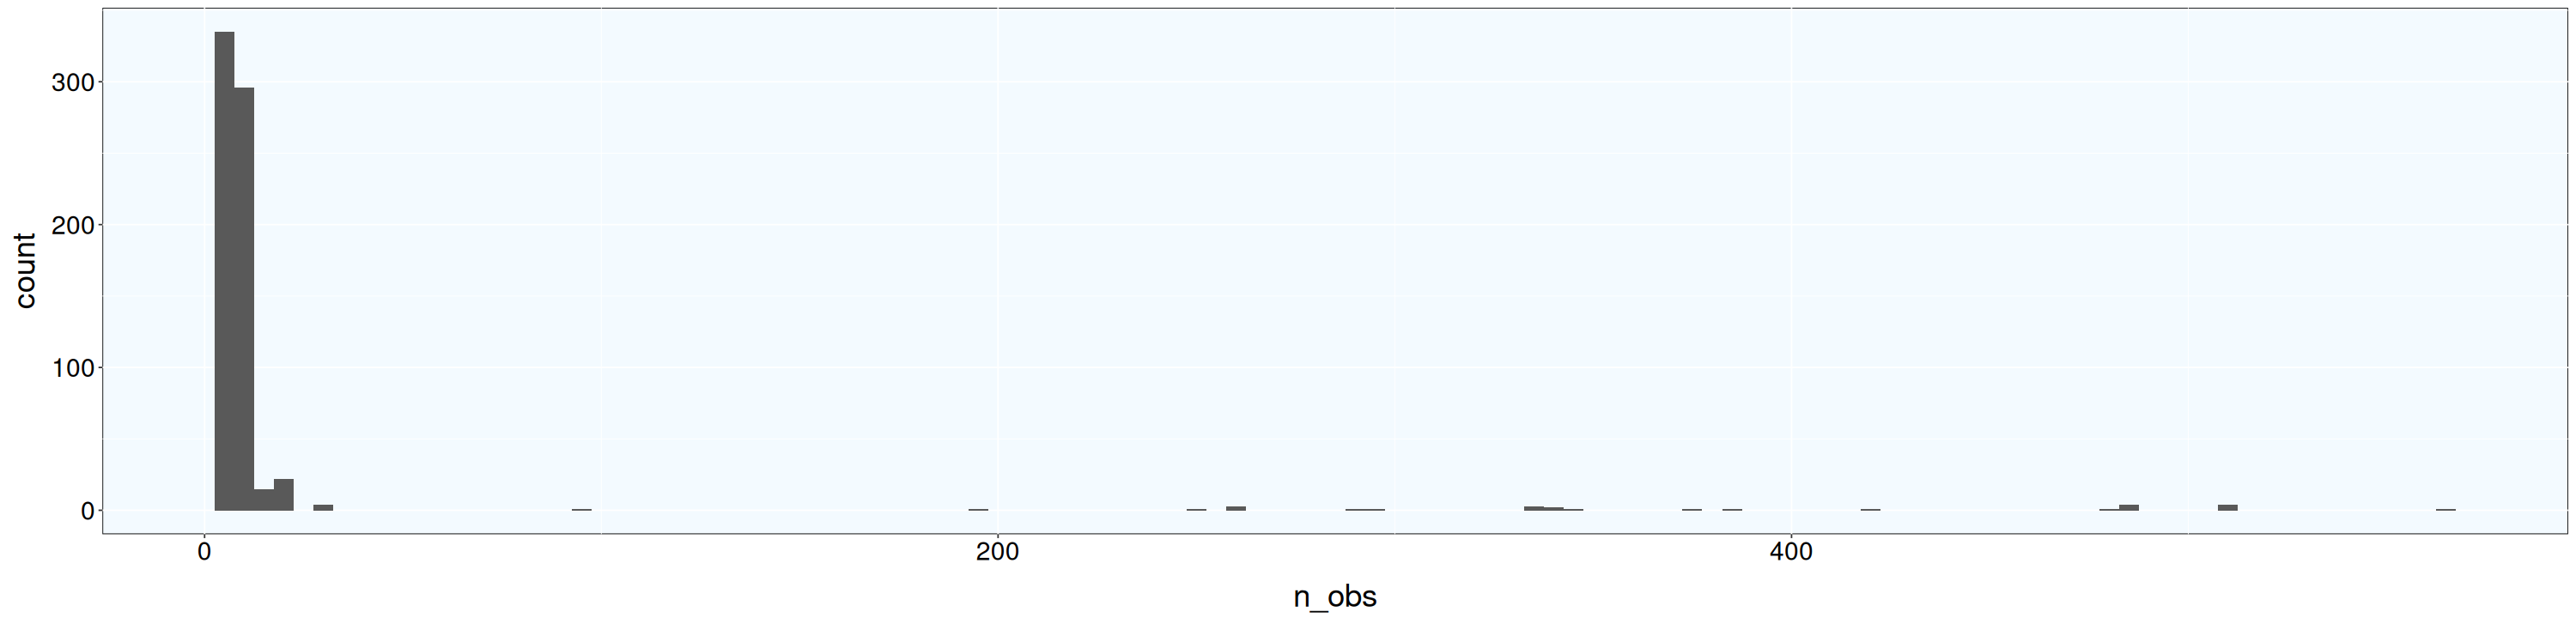

In [39]:
size (25, 6)
data %>%
    summarise (n_obs = n(), .by = pmid) %>%
    ggplot +
        geom_histogram (aes (x = n_obs), binwidth = 5)

In [40]:
dim (data)

[1] 15654   270

In [41]:
data = data %>%
    mutate (n_obs = n(), .by = pmid)

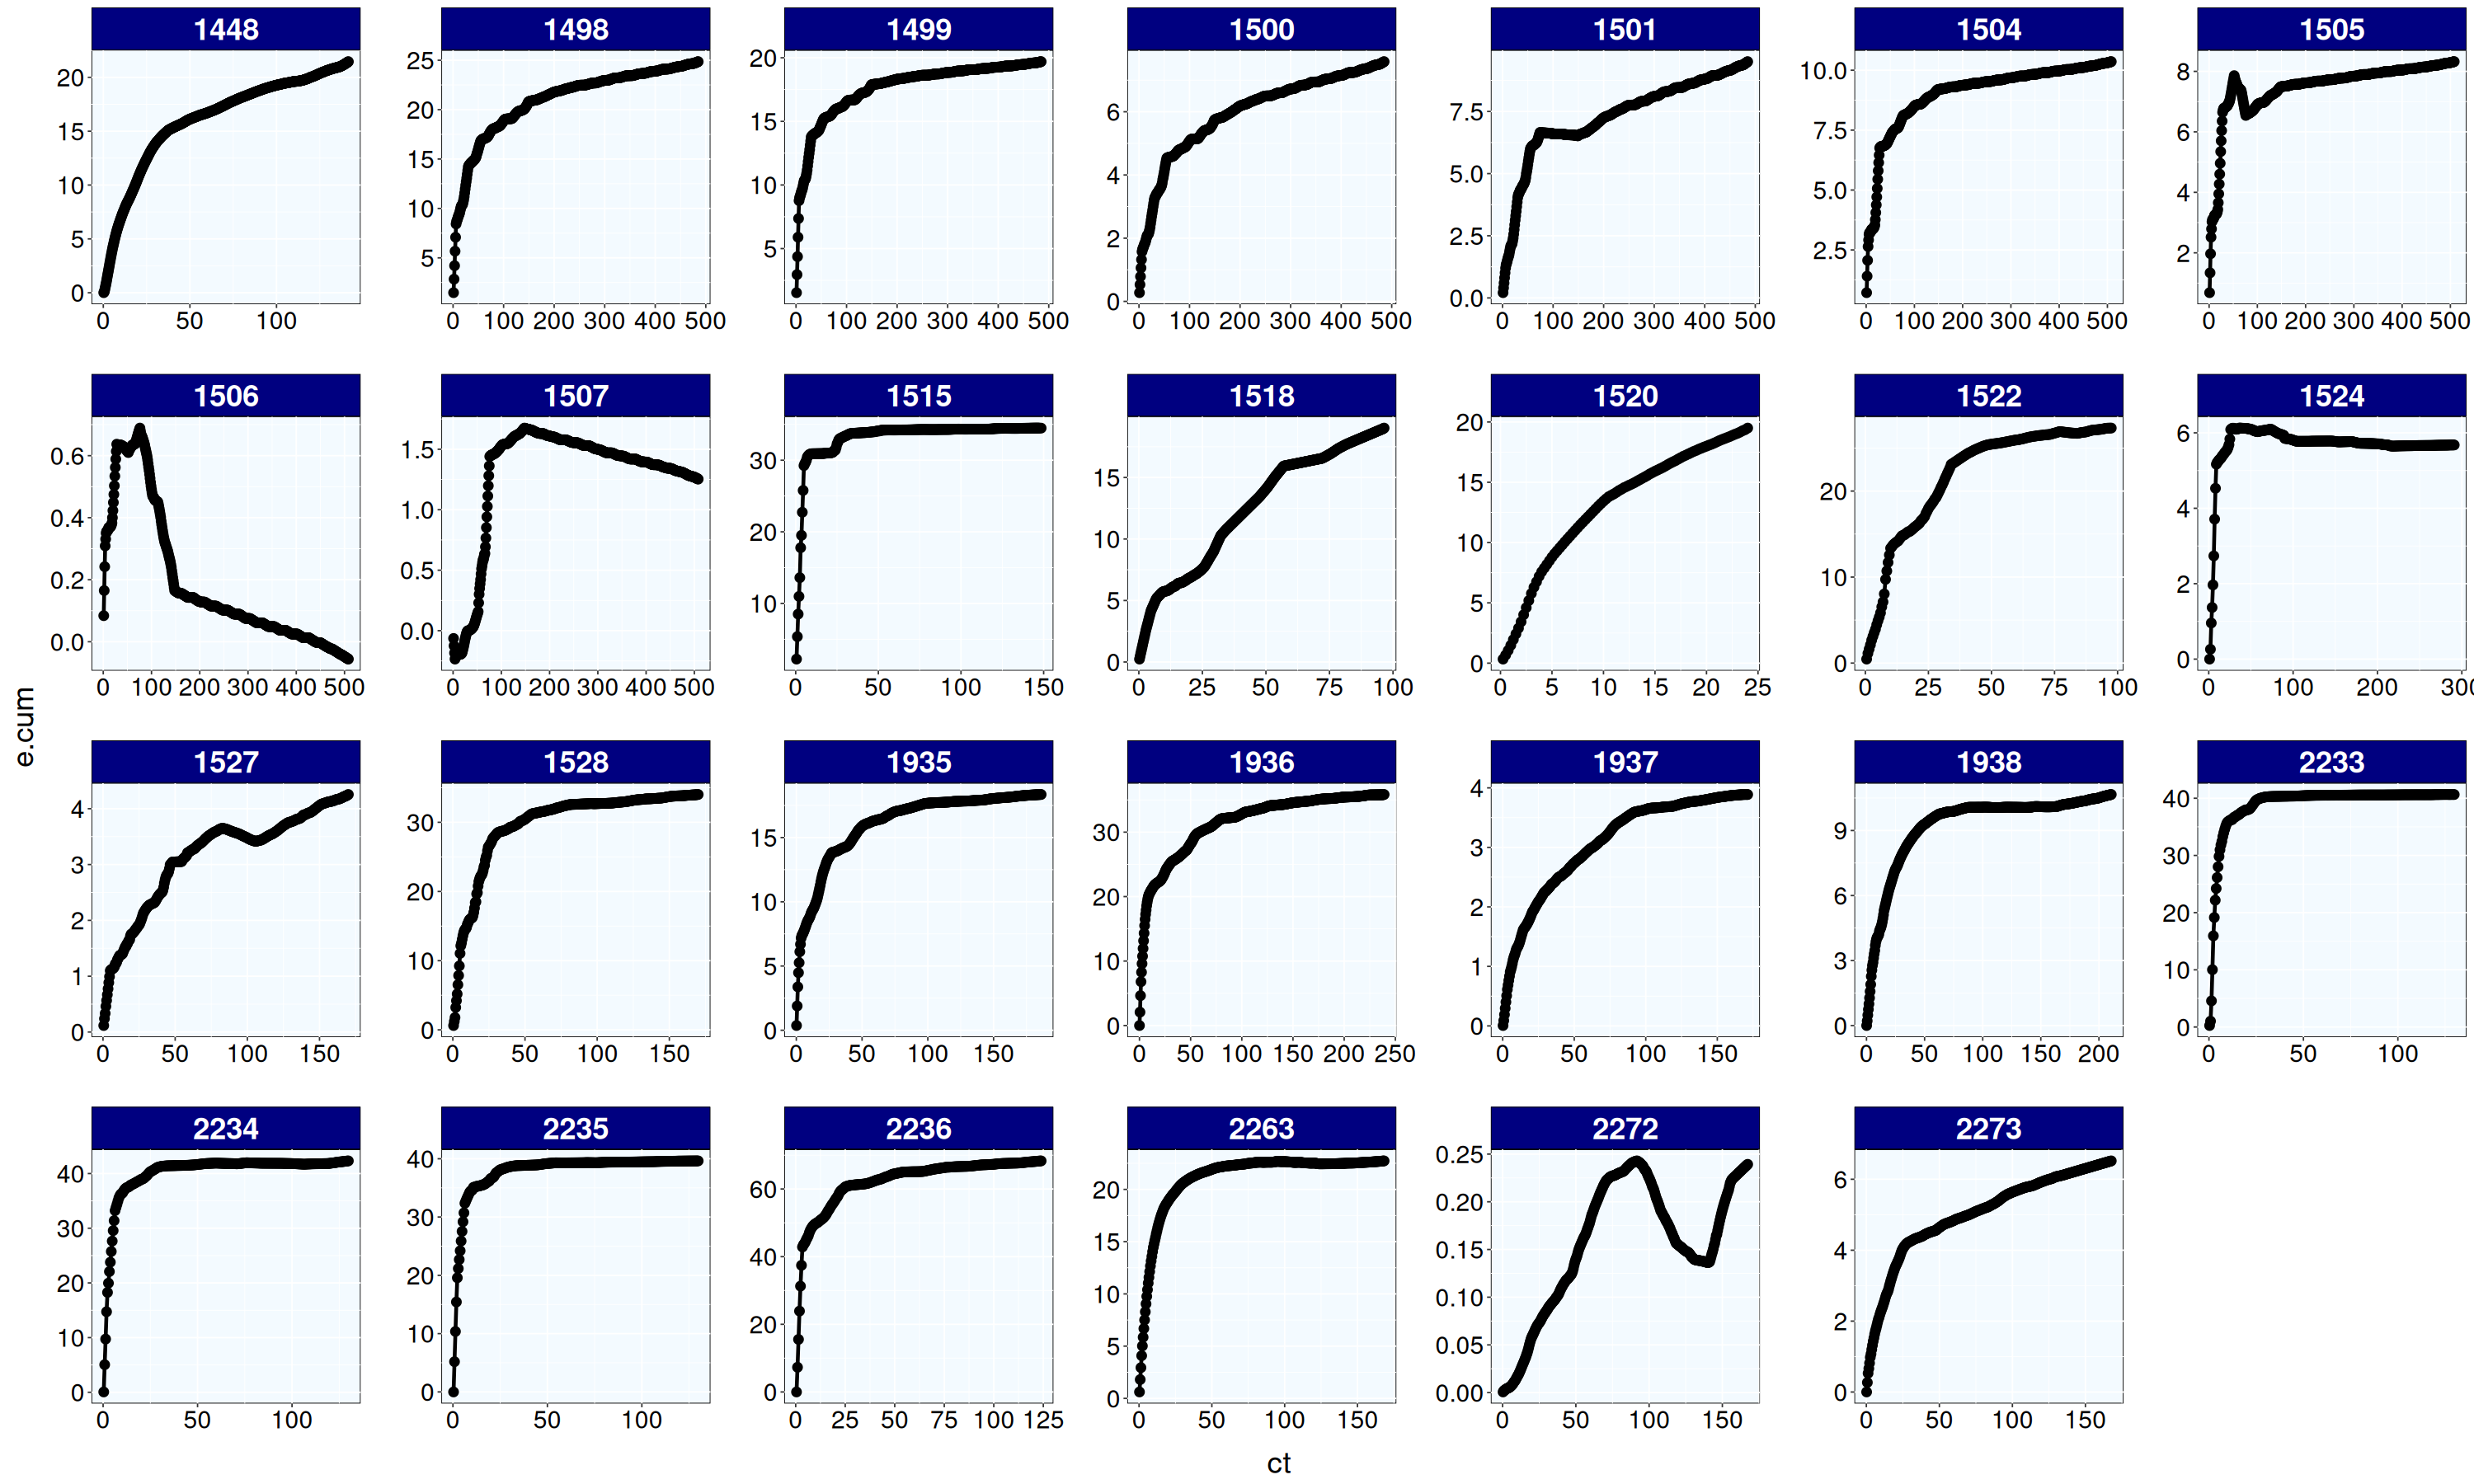

In [42]:
size (25, 15)
data %>%
    filter (n_obs > 50) %>%
    ggplot () +
        geom_point (aes (x = ct, y = e.cum)) +
        geom_line (aes (x = ct, y = e.cum)) +
        facet_wrap (~ pmid, scales = "free", ncol = 7)

We are going to remove some measurement of these trials. We will then need to recompute dt and j.NH3.

In [43]:
y = c (seq(from = 2, to = 10, by = 2), seq (from = 12, to = 20, by = 4), seq (from = 24, to = 800, by = 8))

In [44]:
data = data %>%
    mutate (index = row_number()) %>%
    mutate (tsup = y [which (y - ct >= 0)[1]], .by = index, .after = ct) %>%
    mutate (diff = tsup - ct, .after = tsup) %>%
    filter (diff == min (diff) | n_obs < 50, .by = c (tsup, pmid)) 

We recompute dt and j.NH3:

In [45]:
data = data %>%
    mutate (e.cum_shift = c (0, e.cum [1 : (n() - 1)]), .by = pmid) %>%
    mutate (ct_shift = c (0, ct [1 : (n() - 1)]), .by = pmid) %>%
    mutate (dt = ct - ct_shift) %>%
    mutate (j.NH3 = (e.cum - e.cum_shift) / dt) %>%
    select (- e.cum_shift, - ct_shift) 

Checking that measurements were properly removed:

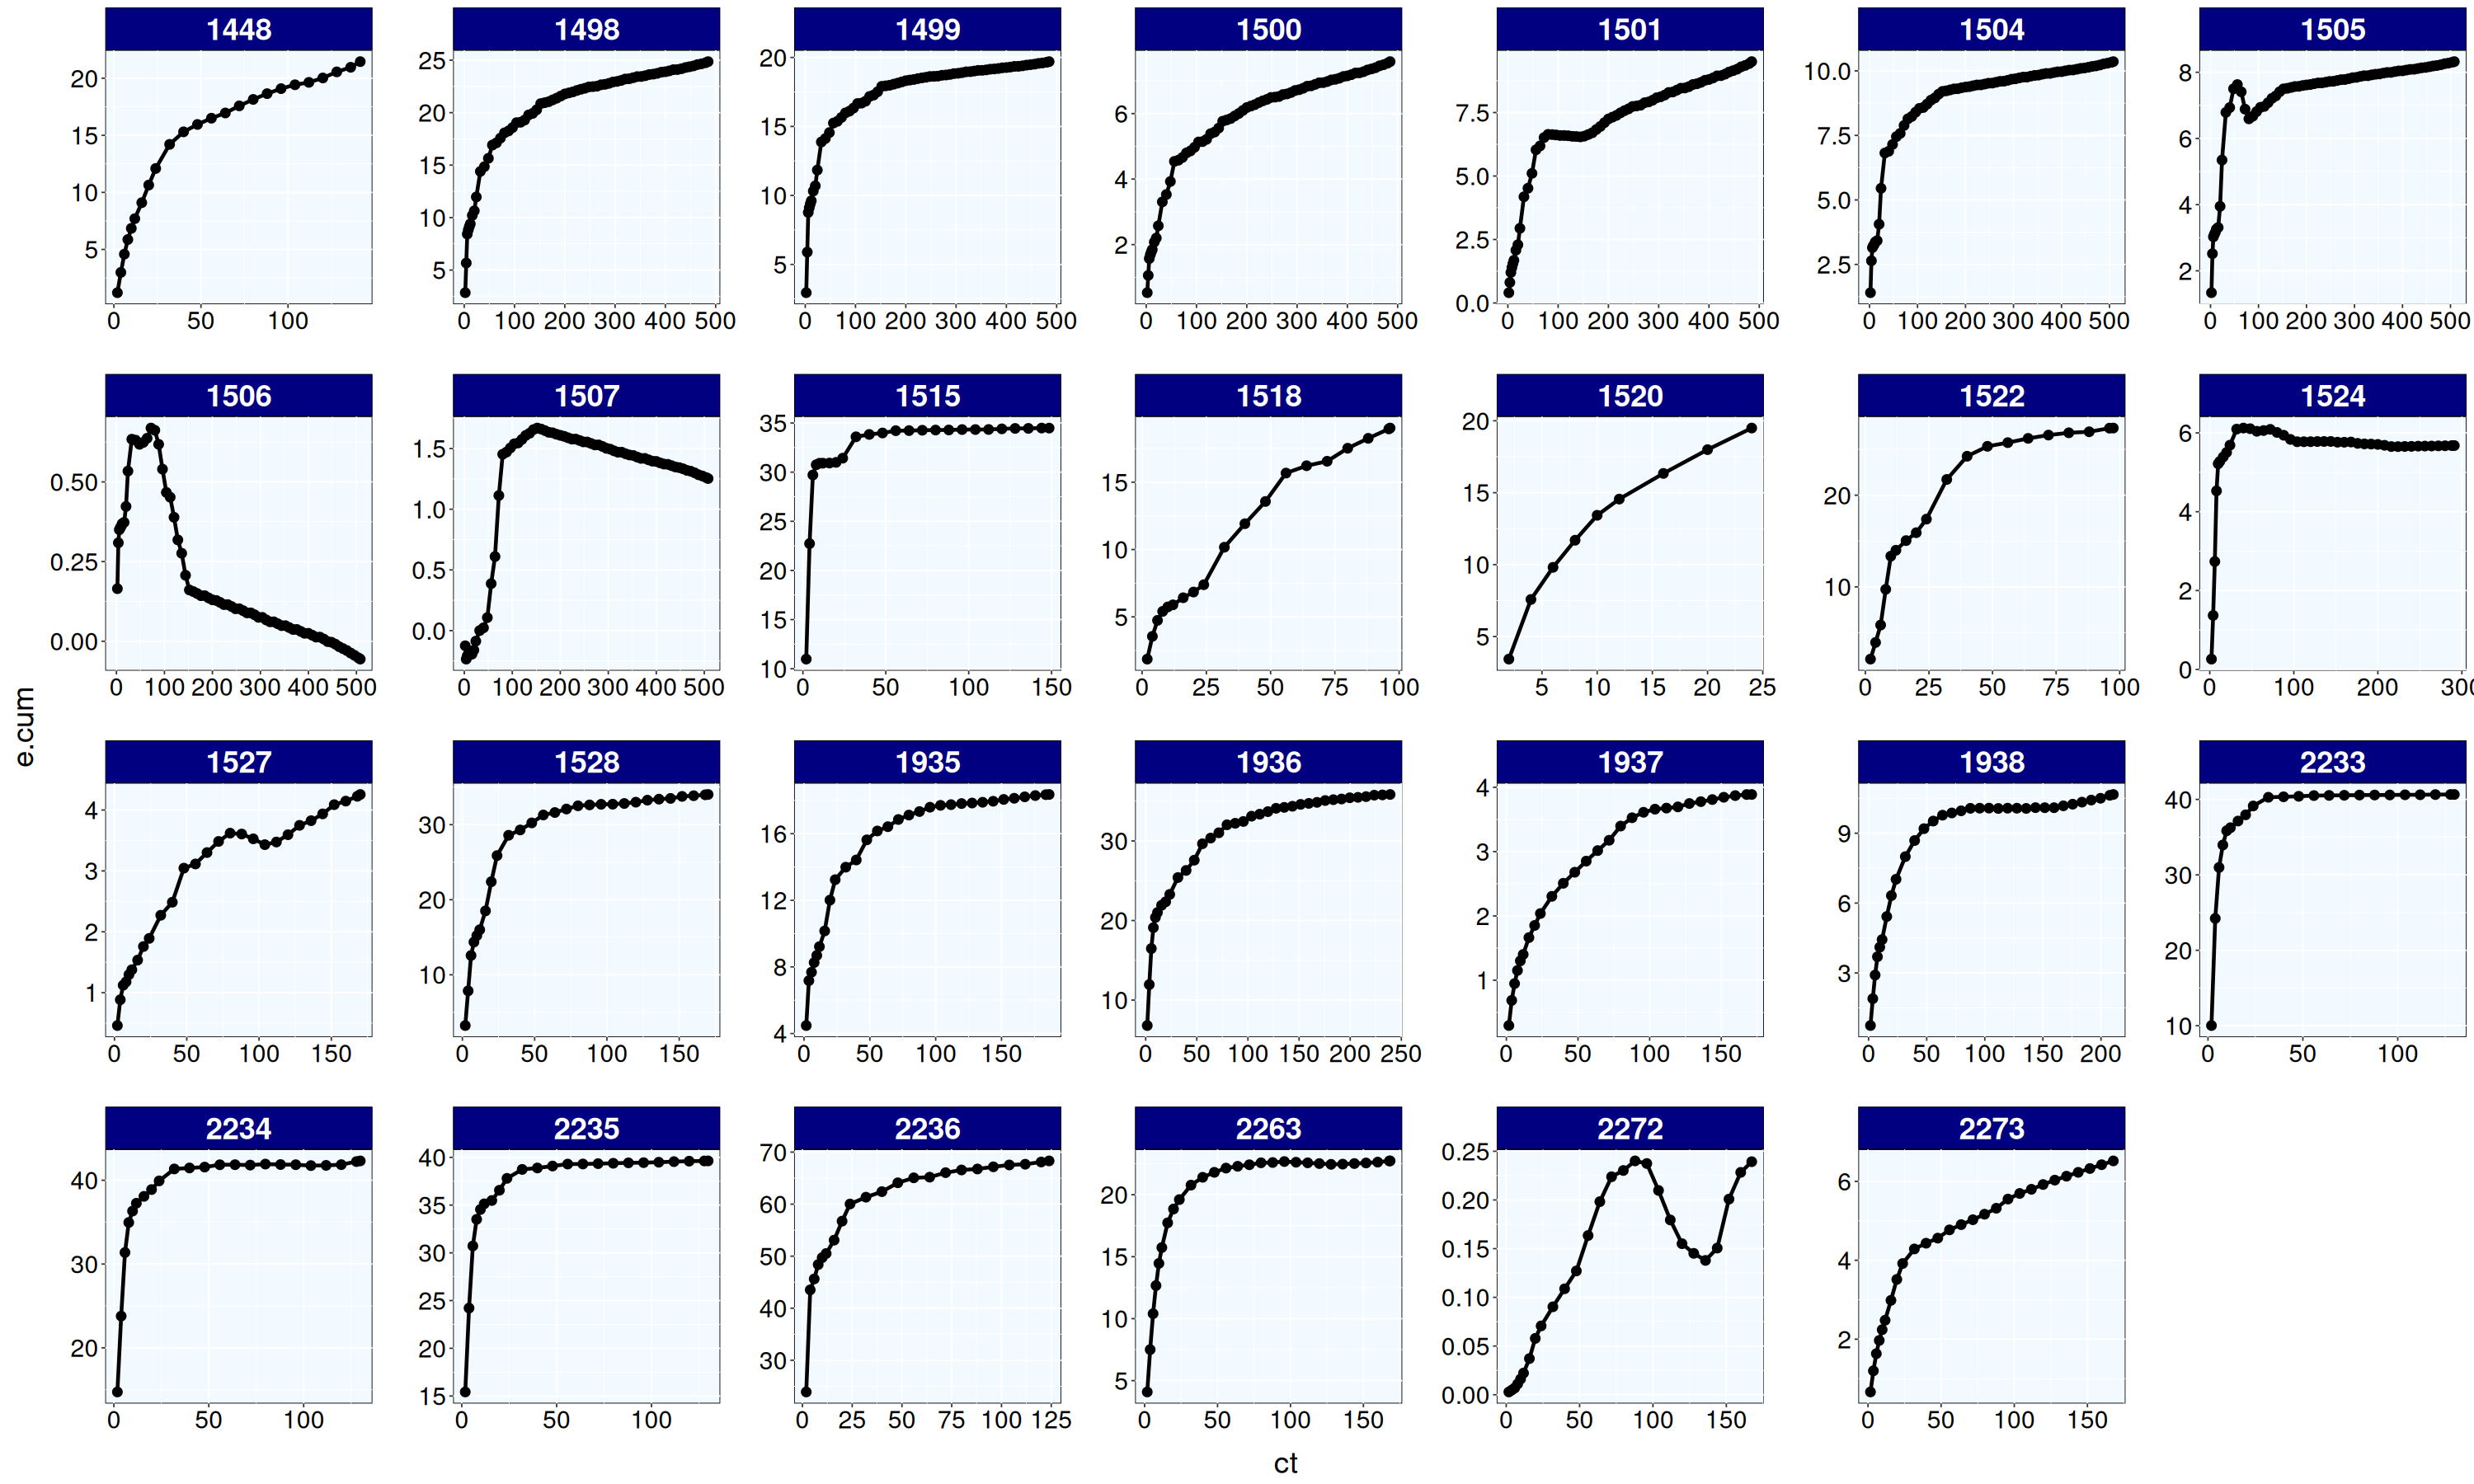

In [46]:
size (25, 15)
data %>%
    filter (n_obs > 50) %>%
    ggplot () +
        geom_point (aes (x = ct, y = e.cum)) +
        geom_line (aes (x = ct, y = e.cum)) +
        facet_wrap (~ pmid, scales = "free", ncol = 7)

In [47]:
data = data %>% 
    select (- n_obs, - tsup, - diff, - index)

In [48]:
dim (data)

[1] 6562  269

In [49]:
data$pmid %>% unique %>% length

[1] 699

Visual checking of all the trials.

In [50]:
pmids = data$pmid %>% unique

data_plot_check = NULL

for (i in c (1 : length(pmids))){
    df_tmp = data %>% filter (pmid == pmids[i])
    df_tmp = rbind (df_tmp[1,], df_tmp)
    df_tmp$e.cum[1] = 0
    df_tmp$ct[1] = 0
    data_plot_check = rbind (data_plot_check, df_tmp)
}

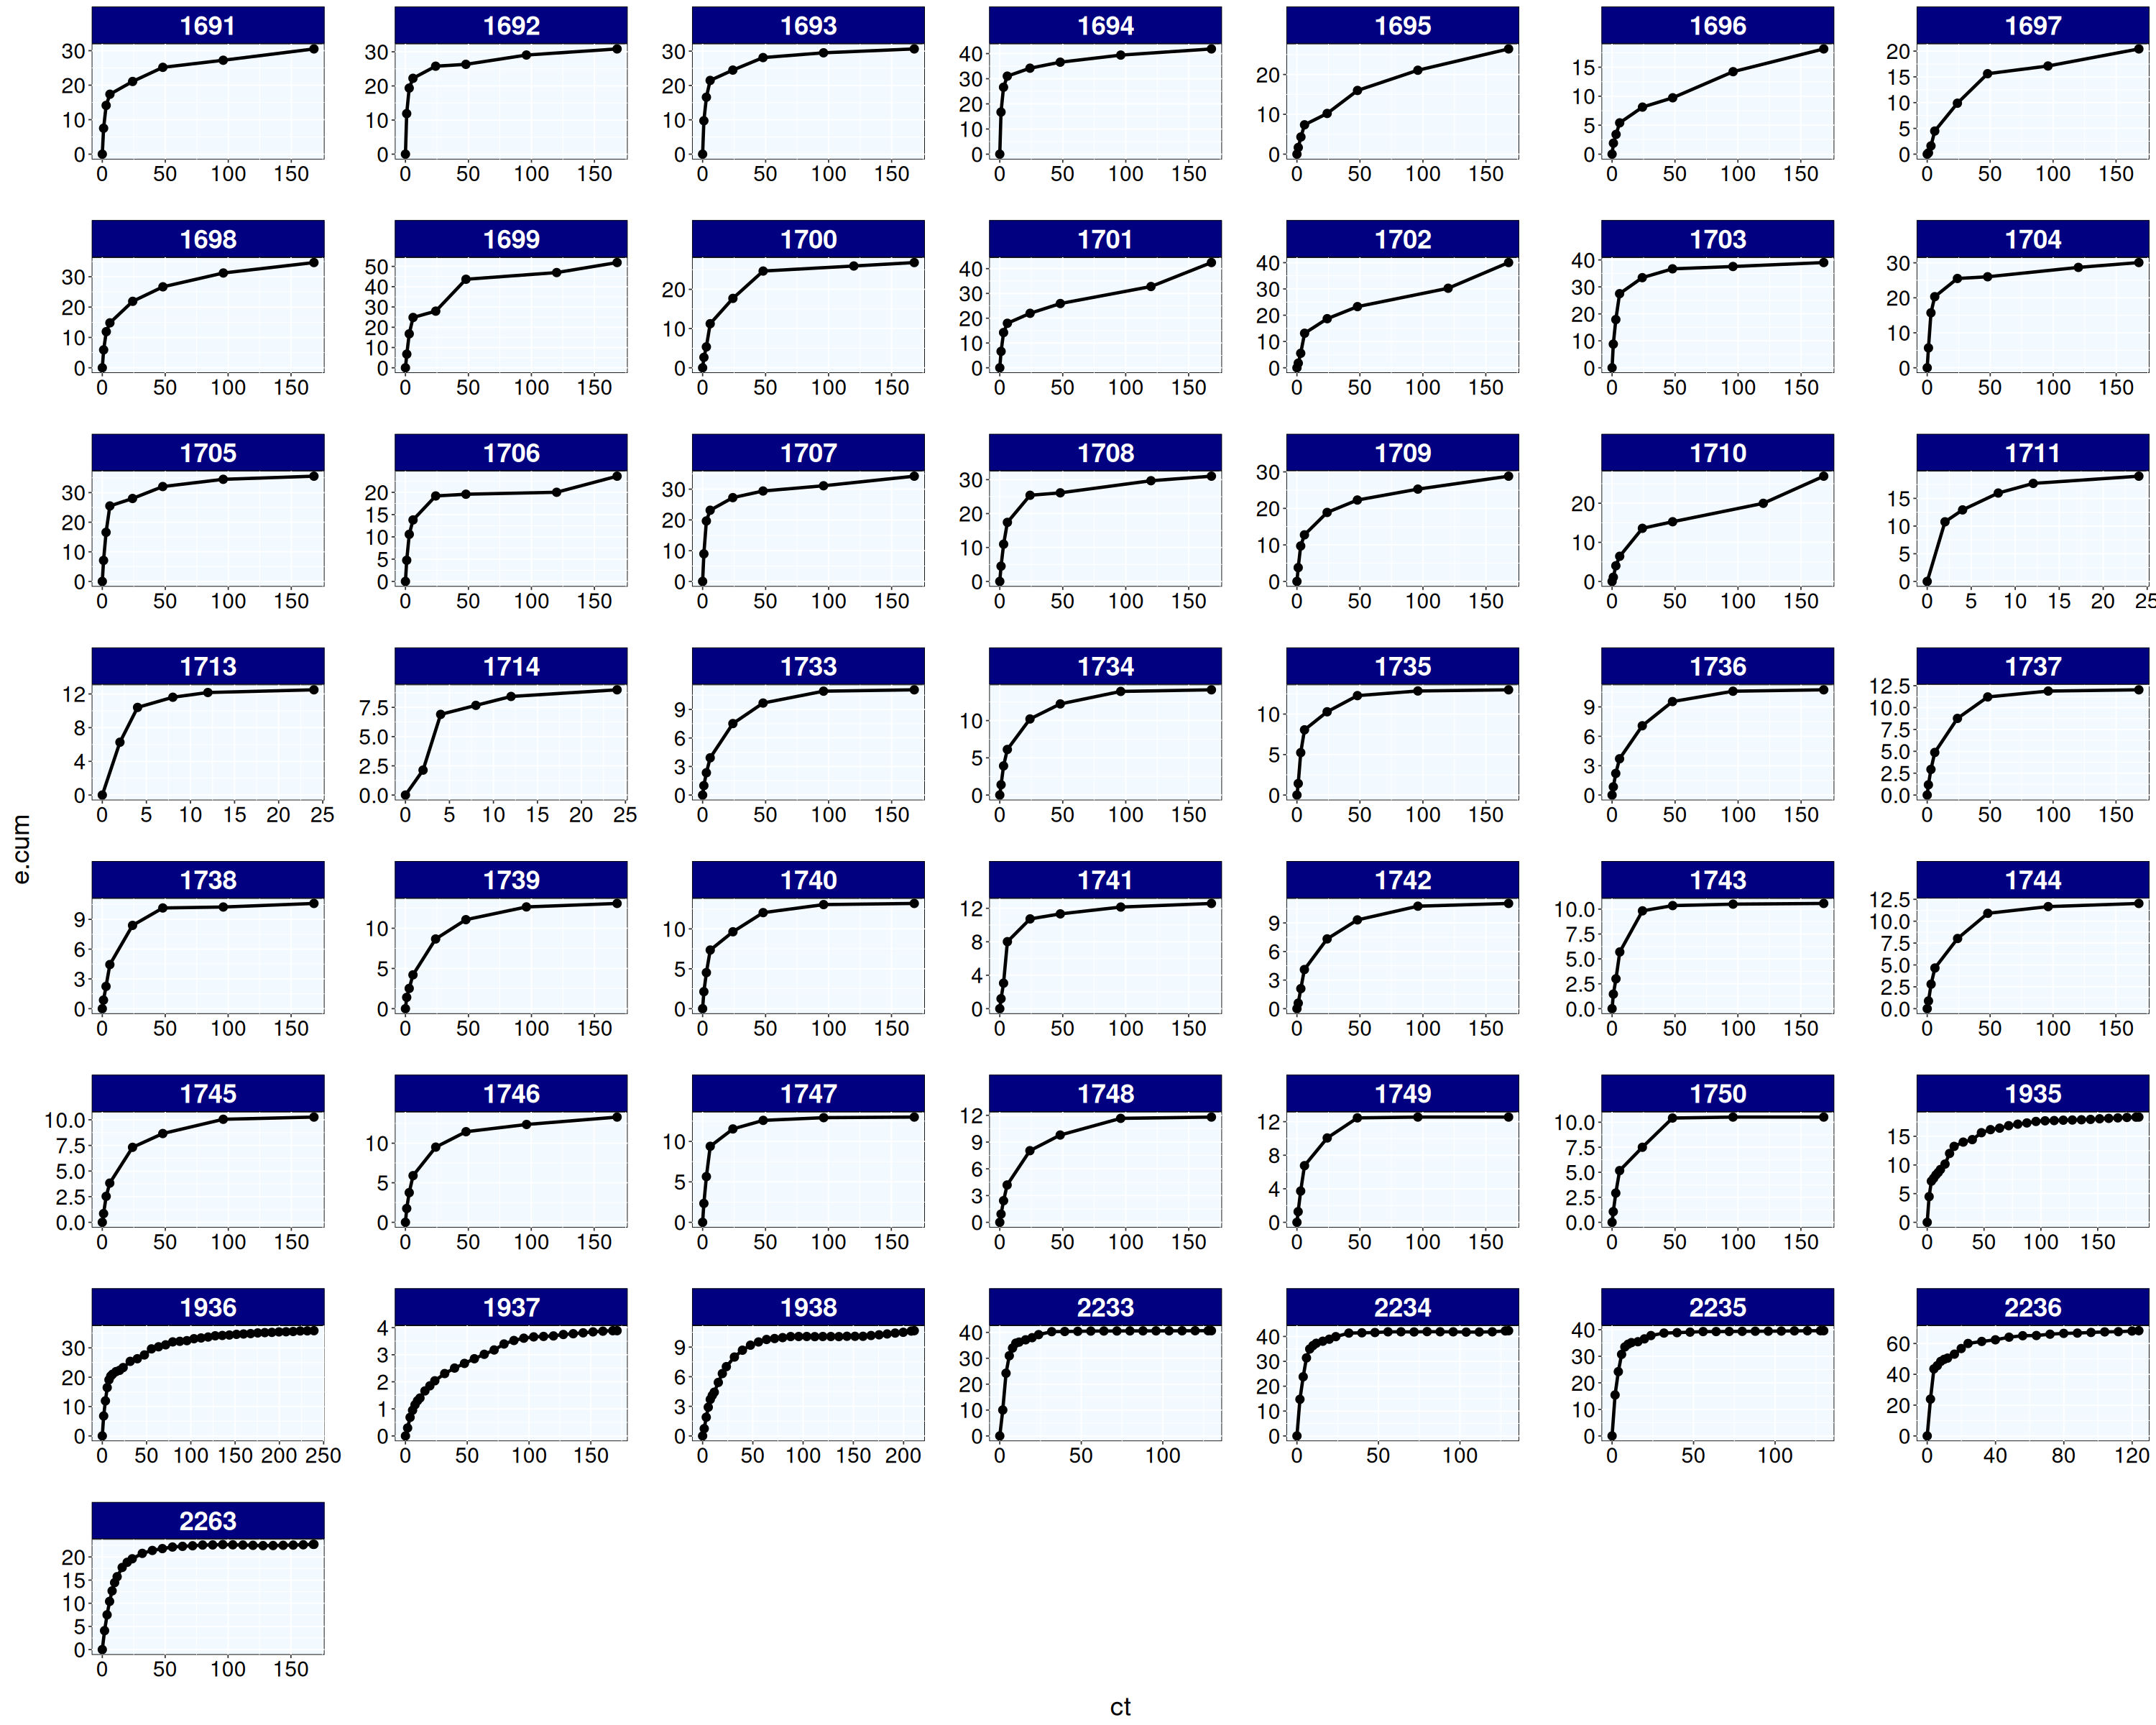

In [51]:
size (25, 20)

k = 7
pmids_tmp = pmids[c(((k-1)*50 + 1) : (k * 50))]

data_plot_check %>%
    filter (pmid %in% pmids_tmp) %>%
    ggplot () +
        geom_point (aes (x = ct, y = e.cum)) +
        geom_line (aes (x = ct, y = e.cum)) +
        facet_wrap (~ pmid, scales = "free", ncol = 7)

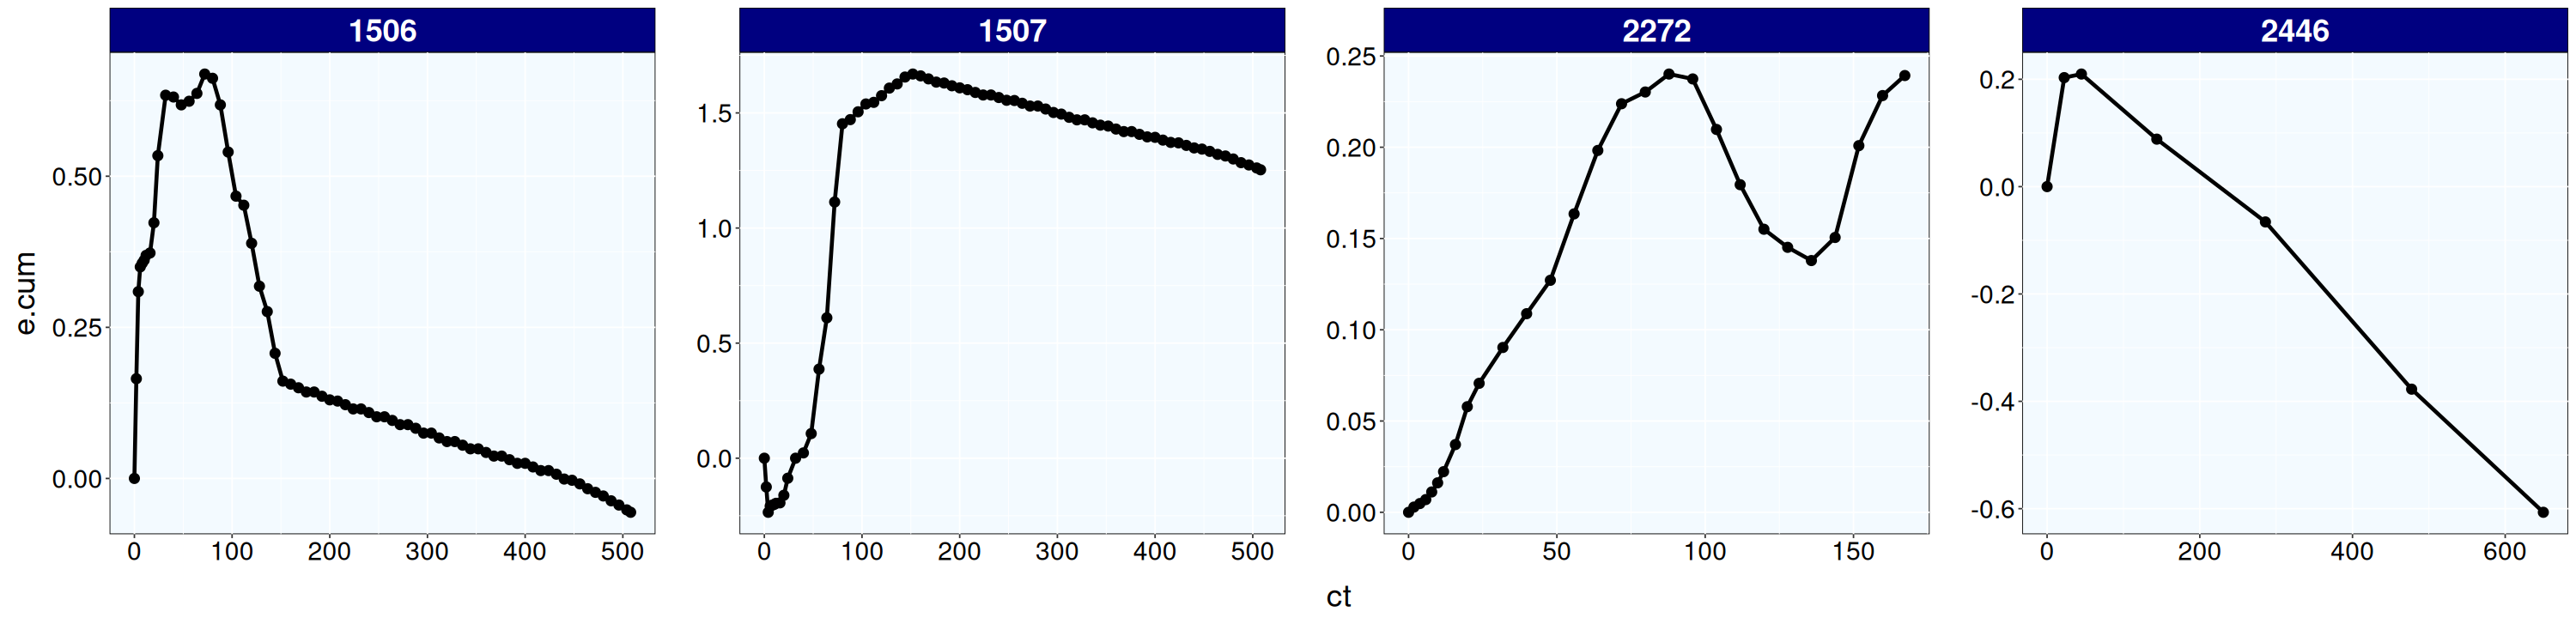

In [52]:
size(25, 6)
data_plot_check %>%
    filter (pmid %in% c(1506, 1507, 2272, 2446)) %>%
    ggplot () +
        geom_point (aes (x = ct, y = e.cum)) +
        geom_line (aes (x = ct, y = e.cum)) +
        facet_wrap (~ pmid, scales = "free", ncol = 4)

In [53]:
pdat %>%
    filter (pmid %in% c(1506, 1507, 2272, 2446)) %>%
    select (pmid, app.method, tan.app, incorp, time.incorp, app.rate)

pmid,app.method,tan.app,incorp,time.incorp,app.rate
<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1506,bc,39.200,shallow,0,49.000
1507,bc,39.200,shallow,0,49.000
2272,os,67.550,none,NA,35.000
2446,bsth,23.489,none,NA,36.635


We keep only measurement before t = 178.

In [54]:
data = data %>%
    filter (ct < 178)

In [55]:
data = data %>%
    select (e.cum, e.rel, j.NH3, pmid, eid, exper, field, meas.tech, country, inst, ct, dt, air.temp, wind.2m, rain.rate, tan.app, 
            app.rate, man.dm, man.ph, man.source, t.incorp, app.mthd, incorp) %>%
    mutate_if (is.character, as.factor)

Checking that there is no NAs

In [56]:
is.na (data) %>% sum

[1] 619

Checking the relationships between the flux, the cumul, ct and dt.

In [57]:
# check
data_check = data %>%
    mutate (ct_check = cumsum (dt), .by = pmid) %>%
    mutate (e.cum_shift = c (0, e.cum [1 : (n() - 1)]), .by = pmid) %>%
    mutate (j.NH3_check = (e.cum - e.cum_shift) / dt) %>%
    mutate (e.rel_check = e.cum / tan.app)

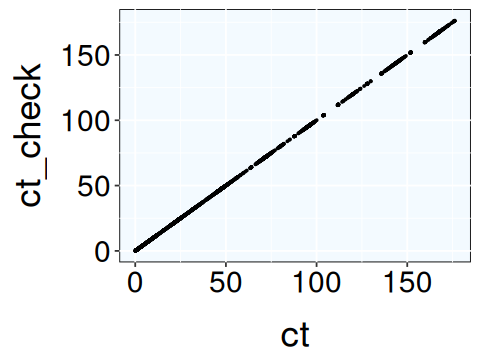

In [58]:
size (4, 3)
data_check %>%
    ggplot() + geom_point (aes (x = ct, y = ct_check), size = 0.4)

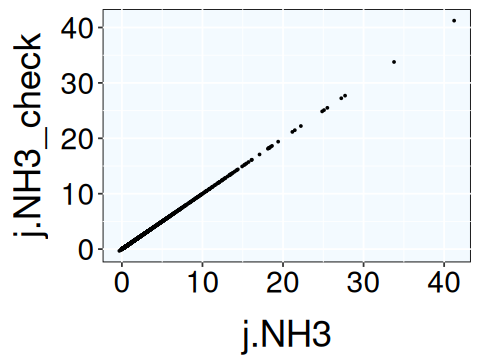

In [59]:
size (4, 3)
data_check %>%
    ggplot() + geom_point (aes (x = j.NH3, y = j.NH3_check), size = 0.4)

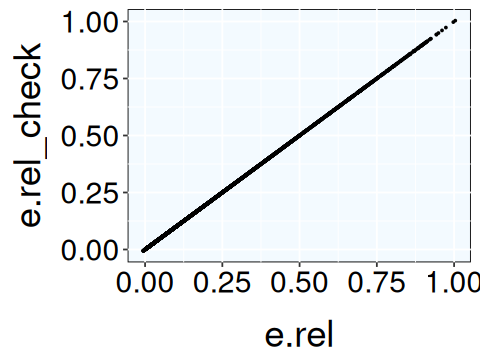

In [60]:
size (4, 3)
data_check %>%
    ggplot() + geom_point (aes (x = e.rel, y = e.rel_check), size = 0.4)

In [61]:
save (data, file = "processed_data/data.Rdata")

# End